code from - https://www.pinecone.io/learn/series/rag/embedding-models-rundown/

In [ ]:
dotenv_file = '/home/amir/source/.env'
load_dotenv(dotenv_file)

In [1]:
!pip install -qU datasets==2.14.6


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
from datasets import load_dataset

data = load_dataset(
    "jamescalam/ai-arxiv-chunked",
    split= "train"
)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [3]:
data

Dataset({
    features: ['doi', 'chunk-id', 'chunk', 'id', 'title', 'summary', 'source', 'authors', 'categories', 'comment', 'journal_ref', 'primary_category', 'published', 'updated', 'references'],
    num_rows: 41584
})

In [7]:
!pip install -qU \
    cohere==4.34 \
    openai


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [12]:
import os
import cohere
import openai

# initialize cohere
os.environ["CO_API_KEY"] = "NC3kwrxb8HBriJU4HNwt7kJ8fZfPcX6aOgXrDVUM"
co = cohere.Client()

# openai doesn't need to be initialized, but need to set api key
# os.environ["OPENAI_API_KEY"] = "your openai api key"

# setting E5 local model

In [13]:
import torch
from transformers import AutoModel, AutoTokenizer

# use GPU if available, on mac can use MPS
device = "cuda" if torch.cuda.is_available() else "cpu"

model_id = "intfloat/e5-base-v2"

# initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModel.from_pretrained(model_id).to(device)
model.eval()

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

# API embeddings call

In [14]:
# cohere embedding function
def embed(docs: list[str]) -> list[list[float]]:
    doc_embeds = co.embed(
        docs,
        input_type="search_document",
        model="embed-english-v3.0"
    )
    return doc_embeds.embeddings

# openai embedding function
def embed(docs: list[str]) -> list[list[float]]:
    res = openai.embeddings.create(
        input=docs,
        model="text-embedding-ada-002"
    )
    doc_embeds = [r.embedding for r in res.data]
    return doc_embeds

# E5 (=bert?) call

In [15]:
def embed(docs: list[str]) -> list[list[float]]:
    docs = [f"passage: {d}" for d in docs]
    # tokenize
    tokens = tokenizer(
        docs, padding=True, max_length=512, truncation=True, return_tensors="pt"
    ).to(device)
    with torch.no_grad():
        # process with model for token-level embeddings
        out = model(**tokens)
        # mask padding tokens
        last_hidden = out.last_hidden_state.masked_fill(
            ~tokens["attention_mask"][..., None].bool(), 0.0
        )
        # create mean pooled embeddings
        doc_embeds = last_hidden.sum(dim=1) / \
            tokens["attention_mask"].sum(dim=1)[..., None]
    return doc_embeds.cpu().numpy()

In [16]:
from tqdm.auto import tqdm
import numpy as np

chunks = data["chunk"]
batch_size = 256

for i in tqdm(range(0, len(chunks), batch_size)):
    i_end = min(len(chunks), i+batch_size)
    chunk_batch = chunks[i:i_end]
    # embed current batch
    embed_batch = embed(chunk_batch)
    # add to existing np array if exists (otherwise create)
    if i == 0:
        arr = embed_batch.copy()
    else:
        arr = np.concatenate([arr, embed_batch.copy()])

  0%|          | 0/163 [00:00<?, ?it/s]

KeyboardInterrupt: 

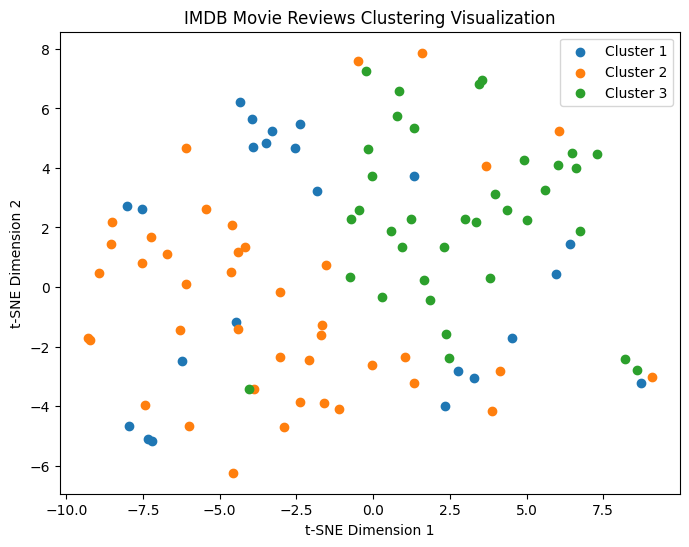

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from datasets import load_dataset

# Load the IMDB Movie Reviews dataset
dataset = load_dataset('imdb')['train']

# Preprocess the dataset to extract text data
texts = [review['text'] for review in dataset]

texts = texts[:100]

# Load the pre-trained E5 model
model = SentenceTransformer('intfloat/e5-base-v2')

# Encode the dataset into embeddings
embeddings = model.encode(texts)

# Evaluate the model using clustering and t-SNE visualization

# Clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Adjust the number of clusters as needed
kmeans.fit(embeddings)
cluster_labels = kmeans.labels_

# t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(embeddings)

# Visualize the clusters
plt.figure(figsize=(8, 6))
for i in range(max(cluster_labels) + 1):
    plt.scatter(tsne_embeddings[cluster_labels == i, 0], tsne_embeddings[cluster_labels == i, 1], label=f"Cluster {i+1}")
plt.legend()
plt.title("IMDB Movie Reviews Clustering Visualization")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

# Further evaluation and analysis can be done based on the specific requirements.


In [21]:
len(texts[:100])

100